In [9]:
#Step 1 Combining all data sets together
import pandas as pd
import glob
import numpy as np
file_paths = ["NVDA_2020.csv","NVDA_2021.csv","NVDA_2022.csv"]
df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list,ignore_index=True)

print(df.info())
print(df.head())

df.to_csv("merged_options_data.csv", index=False)
print(df.describe())
#Dropping all nonessential
df = df[df["DaysToExp"]>=0]
zero_cols = ["Price", "UnderlyingPrice", "AskPrice", "BidPrice"]
df = df[(df[zero_cols] > 0).all(axis=1)]
threshold = df["LastSize"].quantile(0.99)  # Adjust threshold as needed
df = df[df["LastSize"] <= threshold]
greeks = ["Delta", "Gamma", "Theta", "Vega", "RHO"]
print((df[greeks] == 0).mean())  # Percentage of zeros per Greek
df = df[(df[greeks] != 0).any(axis=1)]
drop_cols = ["ID","Dividend","Gamma","Theta","Vega","RHO","BidSize","ASkSize","UnderlyingSymbol","Delta","DateCaptured","PreviousDate","BidTime","AskTime","LastTime"]
df = df.drop(columns=drop_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660114 entries, 0 to 1660113
Data columns (total 34 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Symbol            1660114 non-null  object 
 1   Strike            1660114 non-null  float64
 2   OptionType        1660114 non-null  object 
 3   AskPrice          1660114 non-null  float64
 4   ASkSize           1660114 non-null  int64  
 5   AskTime           1628026 non-null  object 
 6   BidPrice          1660114 non-null  float64
 7   BidSize           1660114 non-null  int64  
 8   BidTime           1628022 non-null  object 
 9   Open              1660114 non-null  float64
 10  High              1660114 non-null  float64
 11  Low               1660114 non-null  float64
 12  Last              1660114 non-null  float64
 13  LastSize          1660114 non-null  int64  
 14  LastTime          1417794 non-null  object 
 15  Settle            1660114 non-null  float64
 16  

In [10]:
print(df.head(10))

                    Symbol  Strike OptionType  AskPrice  BidPrice    Open  \
282  NVDA|20201023|240.00C   240.0       Call    302.35    297.60    0.00   
283  NVDA|20201023|240.00C   240.0       Call    308.40    303.80    0.00   
294  NVDA|20201023|245.00C   245.0       Call    297.50    292.60    0.00   
295  NVDA|20201023|245.00C   245.0       Call    302.95    298.90    0.00   
306  NVDA|20201023|250.00C   250.0       Call    292.50    287.60  305.05   
307  NVDA|20201023|250.00C   250.0       Call    298.00    293.90    0.00   
318  NVDA|20201023|255.00C   255.0       Call    287.40    282.50    0.00   
319  NVDA|20201023|255.00C   255.0       Call    292.05    290.20    0.00   
330  NVDA|20201023|260.00C   260.0       Call    282.50    277.60    0.00   
335  NVDA|20201023|260.00C   260.0       Call    276.20    272.75    0.00   

       High     Low    Last  LastSize  Settle  Previous  Volume  Volatility  \
282    0.00    0.00    0.00         0    0.00      0.00       0      2.71

In [11]:
df = df[df["DaysToExp"] > 0].copy()


In [12]:
#STEP 2 COMPUTE GREEKS
import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_greeks(df):
    S = df["UnderlyingPrice"]  # Stock price
    K = df["Strike"]           # Strike price
    T = df["DaysToExp"] / 365  # Convert days to years
    r = df["Rate"]             # Risk-free rate
    sigma = df["Volatility"]   # IV (Implied Volatility)

    # Handle near-expiry cases (avoid division by zero)
    T = np.where(T <= 0, 1/365, T)
    sigma = np.where(sigma <= 0, 0.01, sigma)  # Small non-zero IV

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    df["Delta"] = np.where(df["OptionType"] == "Call", norm.cdf(d1), norm.cdf(d1) - 1)
    df["Gamma"] = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    return df

# Apply the function
df = compute_greeks(df)


In [13]:
df

,Symbol,Strike,OptionType,AskPrice,BidPrice,Open,High,Low,Last,LastSize,...,Previous,Volume,Volatility,Theoretical,Price,UnderlyingPrice,Rate,DaysToExp,Delta,Gamma
282,NVDA|20201023|240.00C,240.0,Call,302.35,297.60,0.00,0.00,0.00,0.00,0,...,0.00,0,2.7172,299.975,299.975,539.91,0.0009,4,0.998617,0.000030
283,NVDA|20201023|240.00C,240.0,Call,308.40,303.80,0.00,0.00,0.00,0.00,0,...,0.00,0,3.6979,306.100,306.100,545.82,0.0009,3,0.995584,0.000071
294,NVDA|20201023|245.00C,245.0,Call,297.50,292.60,0.00,0.00,0.00,0.00,0,...,0.00,0,2.8614,295.050,295.050,539.91,0.0009,4,0.997345,0.000051
295,NVDA|20201023|245.00C,245.0,Call,302.95,298.90,0.00,0.00,0.00,0.00,0,...,0.00,0,3.2452,300.925,300.925,545.82,0.0009,3,0.997946,0.000040
306,NVDA|20201023|250.00C,250.0,Call,292.50,287.60,305.05,305.05,305.05,305.05,2,...,0.00,2,2.7927,290.050,290.050,539.91,0.0009,4,0.997280,0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660109,NVDA|20250117|95.00P,95.0,Put,14.35,12.20,0.00,0.00,0.00,12.15,1,...,12.15,0,0.5631,13.275,13.275,153.39,0.0421,757,-0.134808,0.001744
1660110,NVDA|20250117|95.00P,95.0,Put,15.70,14.20,0.00,0.00,0.00,12.15,1,...,12.15,0,0.5622,14.950,14.950,141.21,0.0431,752,-0.157518,0.002113
1660111,NVDA|20250117|95.00P,95.0,Put,15.75,14.65,15.05,15.05,15.05,15.05,1,...,12.15,1,0.5618,15.050,15.050,140.36,0.0432,751,-0.159237,0.002144
1660112,NVDA|20250117|95.00P,95.0,Put,14.80,13.30,14.75,14.75,14.75,14.75,5,...,15.05,10,0.5742,14.750,14.750,146.03,0.0431,750,-0.148825,0.001930


In [14]:
df.describe()

,Strike,AskPrice,BidPrice,Open,High,Low,Last,LastSize,Settle,Previous,Volume,Volatility,Theoretical,Price,UnderlyingPrice,Rate,DaysToExp,Delta,Gamma
count,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06,1.393646e+06
mean,3.451764e+02,7.321390e+01,7.065008e+01,1.666450e+01,1.722826e+01,1.611731e+01,4.921838e+01,2.564331e+00,4.833439e+01,4.833439e+01,1.519298e+02,6.052254e-01,7.194138e+01,7.194137e+01,3.518688e+02,8.951292e-03,1.917485e+02,6.976903e-02,3.363857e-03
std,2.290852e+02,9.872498e+01,9.721348e+01,3.943876e+01,3.981333e+01,3.911101e+01,7.913822e+01,4.572989e+00,7.875525e+01,7.875525e+01,1.326544e+03,3.910685e-01,9.797885e+01,9.797885e+01,1.993499e+02,1.378734e-02,2.086137e+02,6.214587e-01,4.666235e-03
min,5.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,1.122700e+02,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00
25%,1.700000e+02,4.600000e+00,3.650000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e-01,1.000000e+00,6.300000e-01,6.300000e-01,0.000000e+00,4.471000e-01,4.100000e+00,4.100000e+00,1.881100e+02,6.000000e-04,3.100000e+01,-3.724194e-01,7.521615e-04
50%,2.850000e+02,3.205000e+01,2.975000e+01,1.600000e-01,1.900000e-01,1.200000e-01,1.382000e+01,1.000000e+00,1.280000e+01,1.280000e+01,1.000000e+00,5.131000e-01,3.090000e+01,3.090000e+01,2.590300e+02,9.000000e-04,1.020000e+02,5.499699e-03,2.024682e-03
75%,4.800000e+02,1.043500e+02,1.000500e+02,1.537000e+01,1.687000e+01,1.391000e+01,6.493000e+01,2.000000e+00,6.340000e+01,6.340000e+01,2.100000e+01,6.362000e-01,1.022500e+02,1.022500e+02,5.356000e+02,1.210000e-02,3.010000e+02,6.482705e-01,4.205134e-03
max,1.600000e+03,8.875000e+02,8.785000e+02,8.565500e+02,8.565500e+02,8.565500e+02,8.565500e+02,4.500000e+01,8.565500e+02,8.565500e+02,1.466100e+05,1.495130e+01,8.830001e+02,8.830000e+02,8.279400e+02,4.800000e-02,8.580000e+02,1.000000e+00,1.264891e-01


In [15]:
#Check which gammas are -ve 
df[df["Gamma"] < 0]  # Find negative Gamma values

,Symbol,Strike,OptionType,AskPrice,BidPrice,Open,High,Low,Last,LastSize,...,Previous,Volume,Volatility,Theoretical,Price,UnderlyingPrice,Rate,DaysToExp,Delta,Gamma


In [16]:
#Adding important features 
df["Moneyness"]=df["UnderlyingPrice"]/df["Strike"]
df["Log moneyness"] = np.log(df["UnderlyingPrice"]/df["Strike"])
df["Diff"]=df["UnderlyingPrice"]-df["Strike"]
df["Moneyness_percentile"] = df["Moneyness"].rank(pct=True)
df["Underlying_RollingVol"] = df["UnderlyingPrice"].pct_change().rolling(10).std()


In [17]:
df.head(10)

,Symbol,Strike,OptionType,AskPrice,BidPrice,Open,High,Low,Last,LastSize,...,UnderlyingPrice,Rate,DaysToExp,Delta,Gamma,Moneyness,Log moneyness,Diff,Moneyness_percentile,Underlying_RollingVol
282,NVDA|20201023|240.00C,240.0,Call,302.35,297.60,0.00,0.00,0.00,0.00,0,...,539.91,0.0009,4,0.998617,0.000030,2.249625,0.810764,299.91,0.905155,NaN
283,NVDA|20201023|240.00C,240.0,Call,308.40,303.80,0.00,0.00,0.00,0.00,0,...,545.82,0.0009,3,0.995584,0.000071,2.274250,0.821650,305.82,0.907372,NaN
294,NVDA|20201023|245.00C,245.0,Call,297.50,292.60,0.00,0.00,0.00,0.00,0,...,539.91,0.0009,4,0.997345,0.000051,2.203714,0.790144,294.91,0.901048,NaN
295,NVDA|20201023|245.00C,245.0,Call,302.95,298.90,0.00,0.00,0.00,0.00,0,...,545.82,0.0009,3,0.997946,0.000040,2.227837,0.801031,300.82,0.903311,NaN
306,NVDA|20201023|250.00C,250.0,Call,292.50,287.60,305.05,305.05,305.05,305.05,2,...,539.91,0.0009,4,0.997280,0.000053,2.159640,0.769942,289.91,0.896791,NaN
307,NVDA|20201023|250.00C,250.0,Call,298.00,293.90,0.00,0.00,0.00,305.05,2,...,545.82,0.0009,3,0.997496,0.000049,2.183280,0.780828,295.82,0.899167,NaN
318,NVDA|20201023|255.00C,255.0,Call,287.40,282.50,0.00,0.00,0.00,0.00,0,...,539.91,0.0009,4,0.999007,0.000024,2.117294,0.750139,284.91,0.892486,NaN
319,NVDA|20201023|255.00C,255.0,Call,292.05,290.20,0.00,0.00,0.00,0.00,0,...,545.82,0.0009,3,0.994926,0.000085,2.140471,0.761026,290.82,0.895013,NaN
330,NVDA|20201023|260.00C,260.0,Call,282.50,277.60,0.00,0.00,0.00,294.49,1,...,539.91,0.0009,4,0.997146,0.000058,2.076577,0.730721,279.91,0.887913,NaN
335,NVDA|20201023|260.00C,260.0,Call,276.20,272.75,0.00,0.00,0.00,294.49,1,...,534.44,0.0009,1,0.999076,0.000024,2.055538,0.720538,274.44,0.885488,NaN


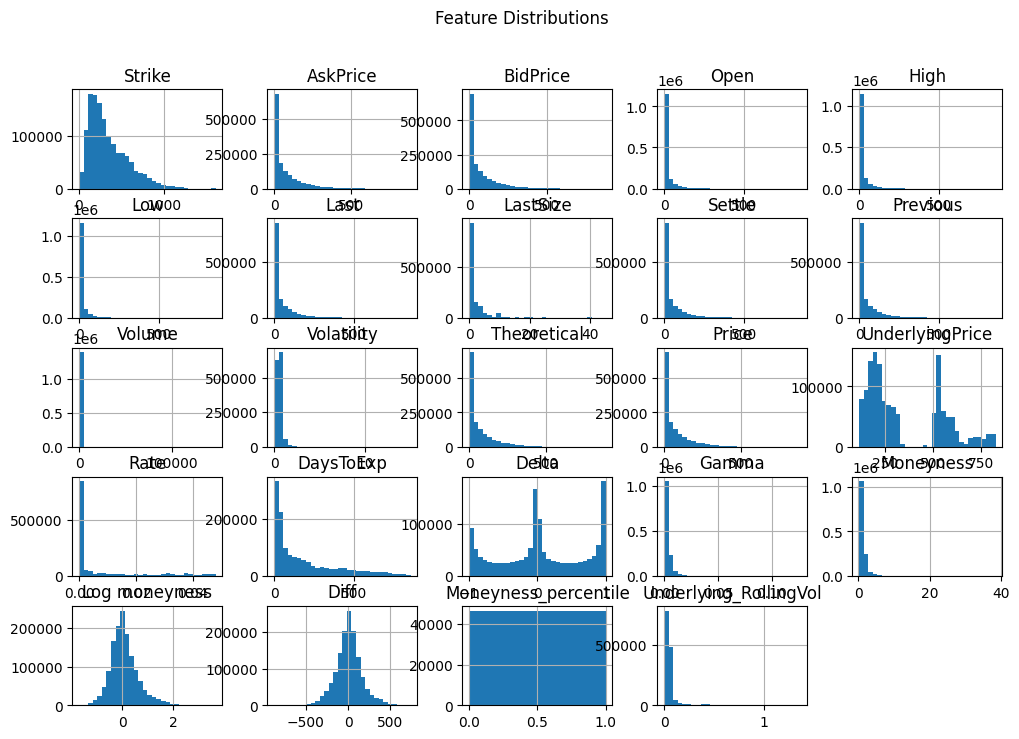

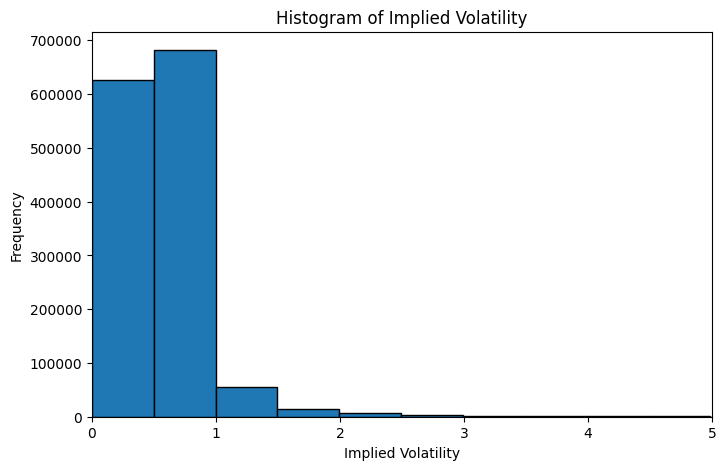

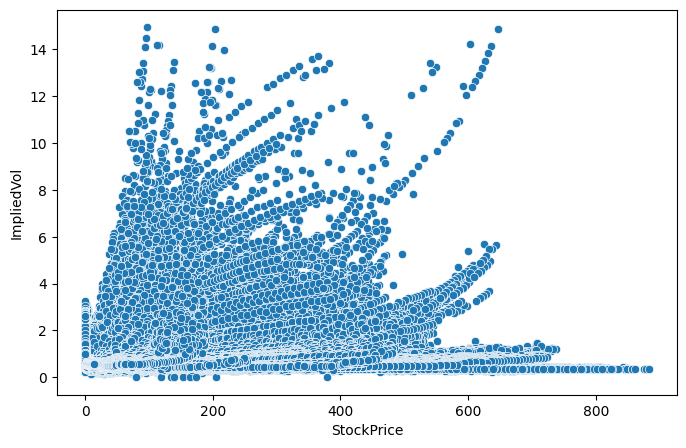

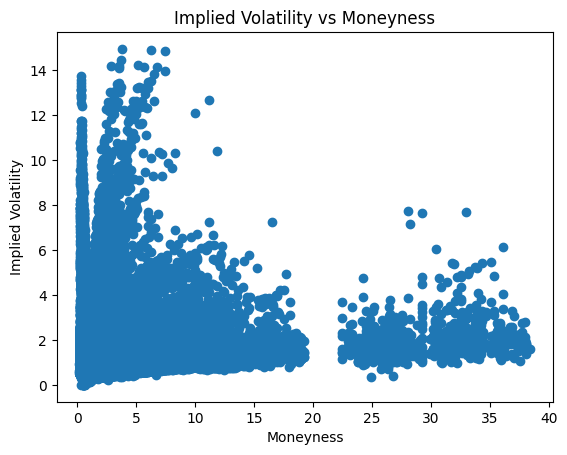

In [18]:
#Ploting to see
import matplotlib.pyplot as plt
import seaborn as sns
#plot a histogram to see
df.hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.show()
plt.figure(figsize=(8, 5))
plt.hist(df["Volatility"], bins=30, edgecolor="black")
plt.xlabel("Implied Volatility")
plt.ylabel("Frequency")
plt.title("Histogram of Implied Volatility")
plt.xlim(0, 5)  # Focus only on relevant values
plt.show()

#plot a stock price dist to see stock price vs implied vol
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["Price"],y=df["Volatility"]) #Make a scatter plot of impleidvol vs stocks price
plt.xlabel("StockPrice")
plt.ylabel("ImpliedVol")

plt.show()



# Scatter plot of Implied Volatility vs Moneyness , tells if intresic extrisnsic
plt.scatter(df["Moneyness"], df["Volatility"])
plt.xlabel("Moneyness")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility vs Moneyness")
plt.show()


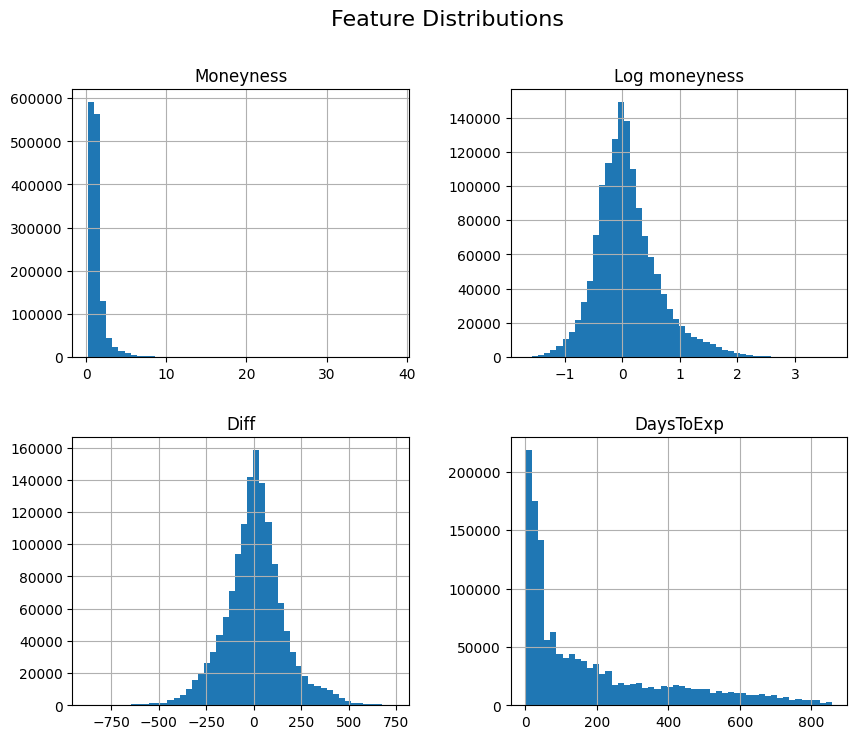

In [19]:
import matplotlib.pyplot as plt  

df[["Moneyness", "Log moneyness", "Diff", "DaysToExp"]].hist(bins=50, figsize=(10, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


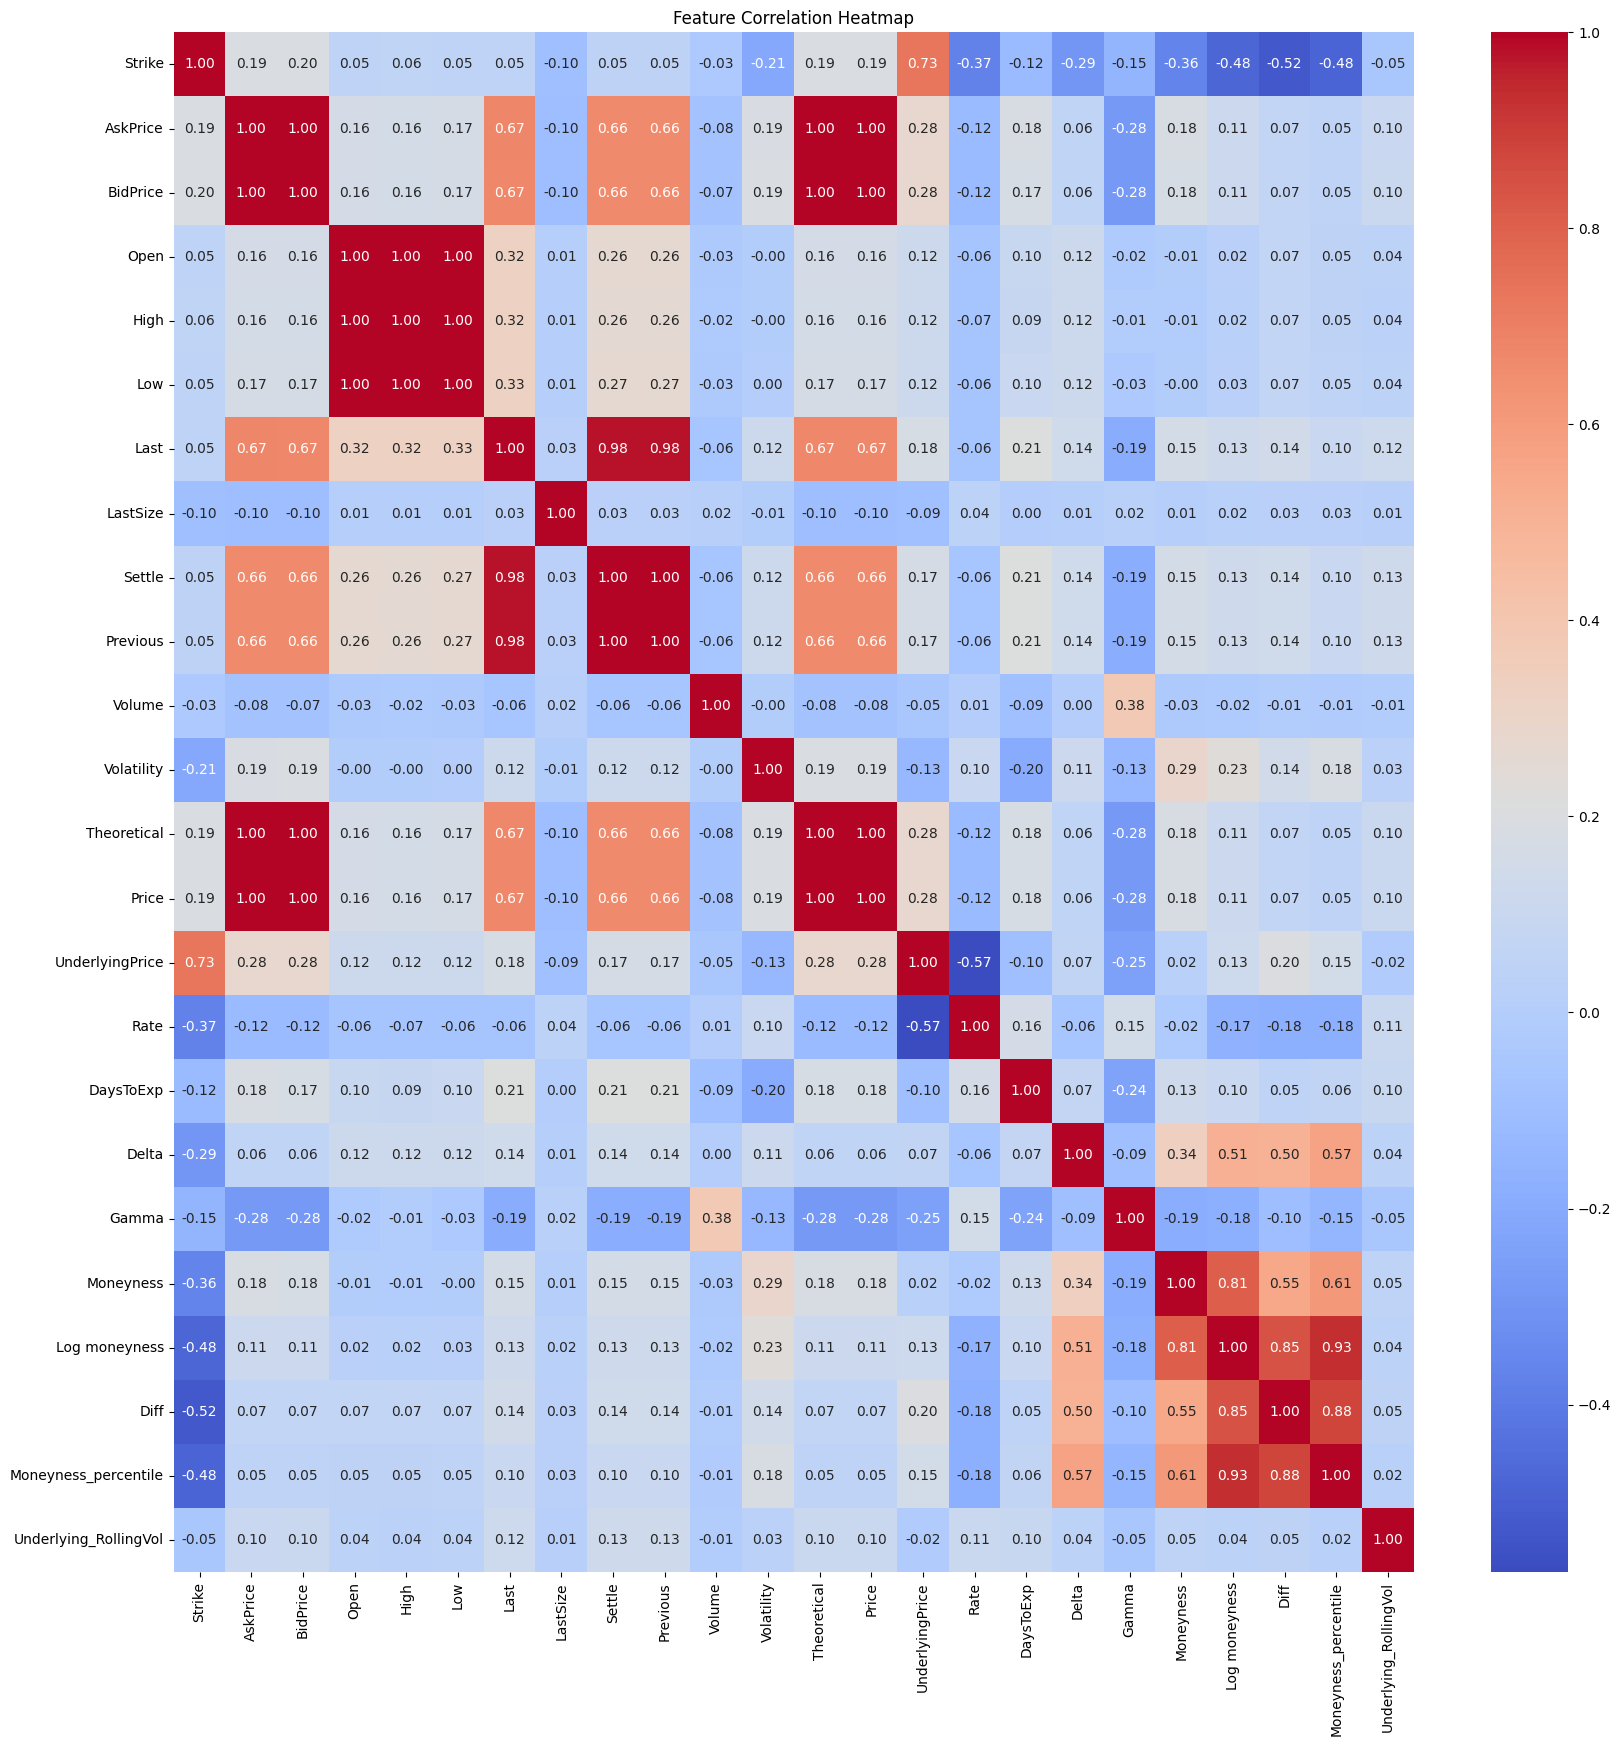

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[float, int])

plt.figure(figsize=(20, 20))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [21]:
df.head(5)

,Symbol,Strike,OptionType,AskPrice,BidPrice,Open,High,Low,Last,LastSize,...,UnderlyingPrice,Rate,DaysToExp,Delta,Gamma,Moneyness,Log moneyness,Diff,Moneyness_percentile,Underlying_RollingVol
282,NVDA|20201023|240.00C,240.0,Call,302.35,297.6,0.00,0.00,0.00,0.00,0,...,539.91,0.0009,4,0.998617,0.000030,2.249625,0.810764,299.91,0.905155,NaN
283,NVDA|20201023|240.00C,240.0,Call,308.40,303.8,0.00,0.00,0.00,0.00,0,...,545.82,0.0009,3,0.995584,0.000071,2.274250,0.821650,305.82,0.907372,NaN
294,NVDA|20201023|245.00C,245.0,Call,297.50,292.6,0.00,0.00,0.00,0.00,0,...,539.91,0.0009,4,0.997345,0.000051,2.203714,0.790144,294.91,0.901048,NaN
295,NVDA|20201023|245.00C,245.0,Call,302.95,298.9,0.00,0.00,0.00,0.00,0,...,545.82,0.0009,3,0.997946,0.000040,2.227837,0.801031,300.82,0.903311,NaN
306,NVDA|20201023|250.00C,250.0,Call,292.50,287.6,305.05,305.05,305.05,305.05,2,...,539.91,0.0009,4,0.997280,0.000053,2.159640,0.769942,289.91,0.896791,NaN


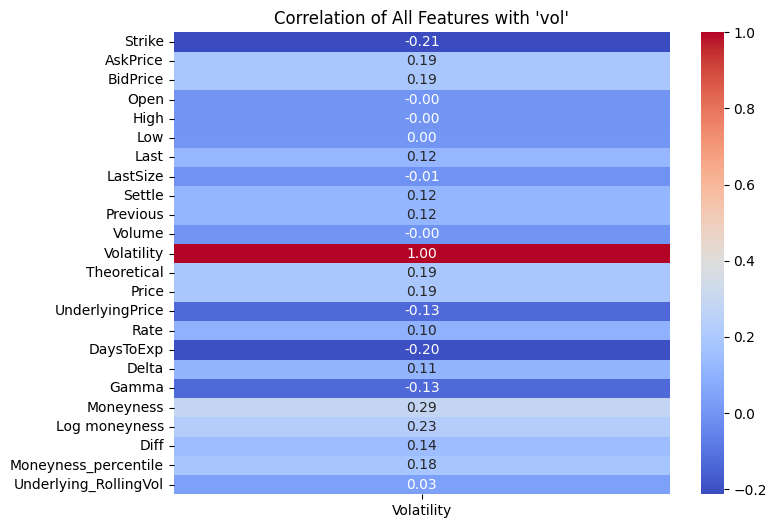

Strike                  -0.213440
AskPrice                 0.189020
BidPrice                 0.190448
Open                    -0.001112
High                    -0.003531
Low                      0.001336
Last                     0.120789
LastSize                -0.006122
Settle                   0.116937
Previous                 0.116937
Volume                  -0.000826
Volatility               1.000000
Theoretical              0.190100
Price                    0.190100
UnderlyingPrice         -0.130772
Rate                     0.099321
DaysToExp               -0.200107
Delta                    0.113044
Gamma                   -0.131915
Moneyness                0.288512
Log moneyness            0.230044
Diff                     0.142852
Moneyness_percentile     0.181379
Underlying_RollingVol    0.034060
Name: Volatility, dtype: float64


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'vol' is in your DataFrame
numeric_df = df.select_dtypes(include=[float, int])
corr_with_vol = numeric_df.corr()['Volatility']

    # Plot the correlation with 'vol'
plt.figure(figsize=(8, 6))
sns.heatmap(corr_with_vol.to_frame(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of All Features with 'vol'")
plt.show()
print(corr_with_vol)

In [23]:
#HOT ENOCODIG
from sklearn.preprocessing import LabelEncoder

df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
print(df.columns)

Index(['Symbol', 'Strike', 'OptionType', 'AskPrice', 'BidPrice', 'Open',
       'High', 'Low', 'Last', 'LastSize', 'Settle', 'Previous', 'Volume',
       'Volatility', 'Theoretical', 'Price', 'UnderlyingPrice', 'Rate',
       'DaysToExp', 'Delta', 'Gamma', 'Moneyness', 'Log moneyness', 'Diff',
       'Moneyness_percentile', 'Underlying_RollingVol'],
      dtype='object')


In [24]:
import pandas as pd

# Example: Let's assume 'OptionType' is the categorical column with 'Call' and 'Put' values
df = pd.get_dummies(df, columns=["OptionType"], drop_first=True)


In [25]:
print(df.head())


                    Symbol  Strike  AskPrice  BidPrice    Open    High  \
282  NVDA|20201023|240.00C   240.0    302.35     297.6    0.00    0.00   
283  NVDA|20201023|240.00C   240.0    308.40     303.8    0.00    0.00   
294  NVDA|20201023|245.00C   245.0    297.50     292.6    0.00    0.00   
295  NVDA|20201023|245.00C   245.0    302.95     298.9    0.00    0.00   
306  NVDA|20201023|250.00C   250.0    292.50     287.6  305.05  305.05   

        Low    Last  LastSize  Settle  ...    Rate  DaysToExp     Delta  \
282    0.00    0.00         0     0.0  ...  0.0009          4  0.998617   
283    0.00    0.00         0     0.0  ...  0.0009          3  0.995584   
294    0.00    0.00         0     0.0  ...  0.0009          4  0.997345   
295    0.00    0.00         0     0.0  ...  0.0009          3  0.997946   
306  305.05  305.05         2     0.0  ...  0.0009          4  0.997280   

        Gamma  Moneyness  Log moneyness    Diff  Moneyness_percentile  \
282  0.000030   2.249625       

In [26]:
df = df.dropna()
df.head(5)

,Symbol,Strike,AskPrice,BidPrice,Open,High,Low,Last,LastSize,Settle,...,Rate,DaysToExp,Delta,Gamma,Moneyness,Log moneyness,Diff,Moneyness_percentile,Underlying_RollingVol,OptionType_Put
342,NVDA|20201023|265.00C,265.0,277.50,272.6,0.00,0.00,0.00,289.52,1,289.52,...,0.0009,4,0.997075,0.000061,2.037396,0.711673,274.91,0.883311,0.011331,False
343,NVDA|20201023|265.00C,265.0,282.30,280.3,0.00,0.00,0.00,289.52,1,289.52,...,0.0009,3,0.992427,0.000120,2.059698,0.722559,280.82,0.885901,0.011331,False
354,NVDA|20201023|270.00C,270.0,272.40,267.5,285.55,285.55,285.55,285.55,2,288.52,...,0.0009,4,0.998932,0.000028,1.999667,0.692981,269.91,0.878358,0.011331,False
355,NVDA|20201023|270.00C,270.0,277.15,275.1,0.00,0.00,0.00,285.55,2,285.55,...,0.0009,3,0.994549,0.000098,2.021556,0.703867,275.82,0.881271,0.011331,False
366,NVDA|20201023|275.00C,275.0,267.50,262.6,0.00,0.00,0.00,0.00,0,0.00,...,0.0009,4,0.996929,0.000067,1.963309,0.674631,264.91,0.873045,0.011331,False


In [27]:
print(df.columns)

Index(['Symbol', 'Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low',
       'Last', 'LastSize', 'Settle', 'Previous', 'Volume', 'Volatility',
       'Theoretical', 'Price', 'UnderlyingPrice', 'Rate', 'DaysToExp', 'Delta',
       'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile',
       'Underlying_RollingVol', 'OptionType_Put'],
      dtype='object')


In [28]:
#Now i need to split the data
from sklearn.model_selection import train_test_split
X = df.drop(columns=["Volatility","Symbol"])  # Drop the target column
y = df["Volatility"]  # Target column
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [29]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
# Set up the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Check performance using cross-validation
cross_val_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -cross_val_scores.mean())  # Average MSE across folds
# Predictions
y_pred = xgb_model.predict(X_test)


Cross-validated MSE: 0.002185288817127843


In [30]:
from sklearn.metrics import mean_squared_error,r2_score
#To calc error
mse = mean_squared_error(y_pred,y_test)
print("Mean squared error is :(MSE):",mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean squared error is :(MSE): 0.002110046546792731
R-squared: 0.9861241592834185


In [31]:
# #LEts use random forest
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error,r2_score
# model = RandomForestRegressor(n_estimators=10,random_state=42)
# model.fit(X_train,y_train)

# #To make prediction 
# y_pred  = model.predict(X_test)

# #To calc mean we do 
# print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
# print("R-squared:", r2_score(y_test, y_pred))

In [32]:
!pip install joblib
import joblib

# Assuming your model is stored in the 'model' variable
joblib.dump(xgb_model, 'iv_predictor_model.pkl')



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['iv_predictor_model.pkl']

In [33]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor

# Step 1: Load the data for 2023 (assuming the data is in CSV format)
df_2023 = pd.read_csv('NVDA_2023.csv')  # Change this to your actual file path

# Step 2: Drop unnecessary columns and handle missing data
drop_cols = ["ID", "Dividend", "Gamma", "Theta", "Vega", "RHO", "BidSize", "AskSize", "UnderlyingSymbol", 
             "Delta", "DateCaptured", "PreviousDate", "BidTime", "AskTime", "LastTime"]
df_2023 = df_2023.drop(columns=drop_cols, errors='ignore')

# Clean the data further, making sure to keep only rows where "DaysToExp" > 0
df_2023 = df_2023[df_2023["DaysToExp"] > 0].copy()

# Step 3: Make sure the columns used in training are consistent
# For this example, we are assuming your model was trained on certain features
# You can add or remove columns based on what was used in your training data
feature_cols = ['Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low', 'Last', 'LastSize', 'Settle',
                'Previous', 'Volume', 'Volatility', 'Theoretical', 'Price', 'UnderlyingPrice', 'Rate',
                'DaysToExp', 'Delta', 'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile', 
                'Underlying_RollingVol', 'OptionType_Put']
print(df.columns)

Index(['Symbol', 'Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low',
       'Last', 'LastSize', 'Settle', 'Previous', 'Volume', 'Volatility',
       'Theoretical', 'Price', 'UnderlyingPrice', 'Rate', 'DaysToExp', 'Delta',
       'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile',
       'Underlying_RollingVol', 'OptionType_Put'],
      dtype='object')


In [79]:


# Step 1: Combining all data sets together
import pandas as pd
import numpy as np

file_paths = ["NVDA_2023.csv"]
df_2023_list = [pd.read_csv(file) for file in file_paths]
df_2023 = pd.concat(df_2023_list, ignore_index=True)

print(df_2023.info())
print(df_2023.head())

df_2023.to_csv("merged_options_data.csv", index=False)
print(df_2023.describe())

# Dropping all nonessential data
df_2023 = df_2023[df_2023["DaysToExp"] >= 0]
zero_cols = ["Price", "UnderlyingPrice", "AskPrice", "BidPrice"]
df_2023 = df_2023[(df_2023[zero_cols] > 0).all(axis=1)]
threshold = df_2023["LastSize"].quantile(0.99)  # Adjust threshold as needed
df_2023 = df_2023[df_2023["LastSize"] <= threshold]
greeks = ["Delta", "Gamma", "Theta", "Vega", "RHO"]
print((df_2023[greeks] == 0).mean())  # Percentage of zeros per Greek
df_2023 = df_2023[(df_2023[greeks] != 0).any(axis=1)]
df_2023_vega = df_2023["Vega"]
drop_cols = ["ID", "Dividend", "Gamma", "Theta", "Vega", "RHO", "BidSize","ASkSize","UnderlyingSymbol", "Delta", "DateCaptured", "PreviousDate", "BidTime", "AskTime", "LastTime"]
df_2023 = df_2023.drop(columns=drop_cols)

# In[129]:

print(df_2023.head(10))

# In[130]:

df_2023 = df_2023[df_2023["DaysToExp"] > 0].copy()

# In[131]:

# Step 2: Compute Greeks
from scipy.stats import norm

def compute_greeks(df_2023):
    S = df_2023["UnderlyingPrice"]  # Stock price
    K = df_2023["Strike"]           # Strike price
    T = df_2023["DaysToExp"] / 365  # Convert days to years
    r = df_2023["Rate"]             # Risk-free rate
    sigma = df_2023["Volatility"]   # IV (Implied Volatility)

    # Handle near-expiry cases (avoid division by zero)
    T = np.where(T <= 0, 1/365, T)
    sigma = np.where(sigma <= 0, 0.01, sigma)  # Small non-zero IV

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    df_2023["Delta"] = np.where(df_2023["OptionType"] == "Call", norm.cdf(d1), norm.cdf(d1) - 1)
    df_2023["Gamma"] = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    return df_2023

# Apply the function
df_2023 = compute_greeks(df_2023)

# In[132]:

print(df_2023.head())

# In[133]:

# Check which gammas are negative
print(df_2023[df_2023["Gamma"] < 0])  # Find negative Gamma values

# In[135]:

# Adding important features 
df_2023["Moneyness"] = df_2023["UnderlyingPrice"] / df_2023["Strike"]
df_2023["Log moneyness"] = np.log(df_2023["UnderlyingPrice"] / df_2023["Strike"])
df_2023["Diff"] = df_2023["UnderlyingPrice"] - df_2023["Strike"]
df_2023["Moneyness_percentile"] = df_2023["Moneyness"].rank(pct=True)
df_2023["Underlying_RollingVol"] = df_2023["UnderlyingPrice"].pct_change().rolling(10).std()

# In[136]:

print(df_2023.head(10))

# In[137]:

# Hot encoding OptionType
from sklearn.preprocessing import LabelEncoder

df_2023.columns = df_2023.columns.str.strip()  # Remove leading/trailing spaces
print(df_2023.columns)

# In[138]:

df_2023 = pd.get_dummies(df_2023, columns=["OptionType"], drop_first=True)

# In[139]:

print(df_2023.head())

# In[140]:

df_2023 = df_2023.dropna()
print(df_2023.head(5))

# In[141]:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554634 entries, 0 to 554633
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Symbol            554634 non-null  object 
 1   Strike            554634 non-null  float64
 2   OptionType        554634 non-null  object 
 3   AskPrice          554634 non-null  float64
 4   ASkSize           554634 non-null  int64  
 5   AskTime           537822 non-null  object 
 6   BidPrice          554634 non-null  float64
 7   BidSize           554634 non-null  int64  
 8   BidTime           537822 non-null  object 
 9   Open              554634 non-null  float64
 10  High              554634 non-null  float64
 11  Low               554634 non-null  float64
 12  Last              554634 non-null  float64
 13  LastSize          554634 non-null  int64  
 14  LastTime          351807 non-null  object 
 15  Settle            554634 non-null  float64
 16  Previous          55

In [35]:
df_2023.columns

Index(['Symbol', 'Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low',
       'Last', 'LastSize', 'Settle', 'Previous', 'Volume', 'Volatility',
       'Theoretical', 'Price', 'UnderlyingPrice', 'Rate', 'DaysToExp', 'Delta',
       'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile',
       'Underlying_RollingVol', 'OptionType_Put'],
      dtype='object')

In [36]:
df.columns

Index(['Symbol', 'Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low',
       'Last', 'LastSize', 'Settle', 'Previous', 'Volume', 'Volatility',
       'Theoretical', 'Price', 'UnderlyingPrice', 'Rate', 'DaysToExp', 'Delta',
       'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile',
       'Underlying_RollingVol', 'OptionType_Put'],
      dtype='object')

In [37]:

# Step 1: Load your model (assuming it's a machine learning model like XGBoost or RandomForest)
import joblib

# Replace with the actual model path
model = joblib.load('iv_predictor_model.pkl')


Predicted Volatility for 2023: [3.403395   2.900191   1.9125353  ... 0.64448106 0.6412083  0.64448106]


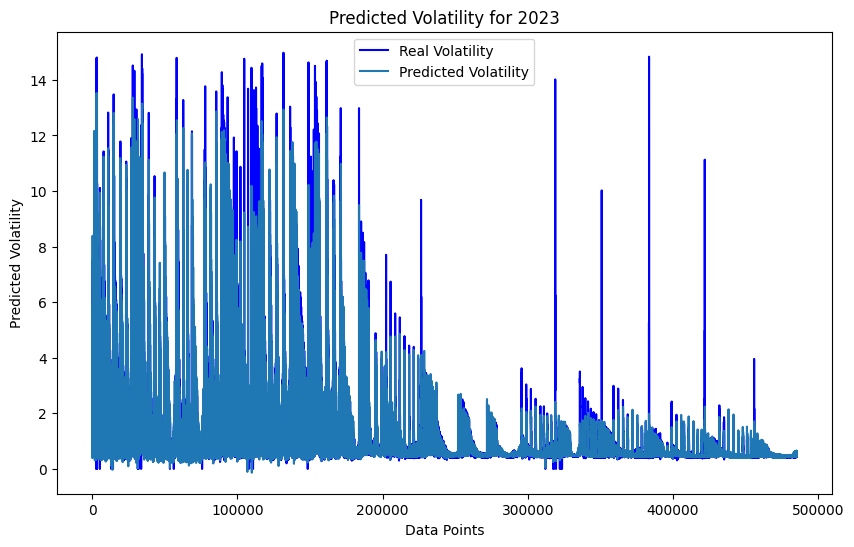

In [38]:
# Step 1: Drop the 'AskSize' column
df_2023_new = df_2023.dropna()

# Step 2: Prepare the features (X_2023) and exclude the target column ("Volatility") and other unnecessary columns
X_2023 = df_2023_new.drop(columns=["Volatility","Symbol"])  # Exclude 'Volatility' and 'OptionType'

# Step 3: Make predictions using your previously trained model
y_pred_2023 = model.predict(X_2023)

# Step 4: Show the predictions
print("Predicted Volatility for 2023:", y_pred_2023)

# Step 5: Plot the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_2023_new["Volatility"].values, label='Real Volatility', color='blue')  # Plot real volatility
plt.plot(y_pred_2023, label='Predicted Volatility')
plt.title('Predicted Volatility for 2023')
plt.xlabel('Data Points')
plt.ylabel('Predicted Volatility')
plt.legend()
plt.show()


Predicted Volatility for Old Data: [2.6325774  3.396188   2.2567427  ... 0.55649    0.55378556 0.54792225]


C:\Users\adity\Documents\ml\my_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


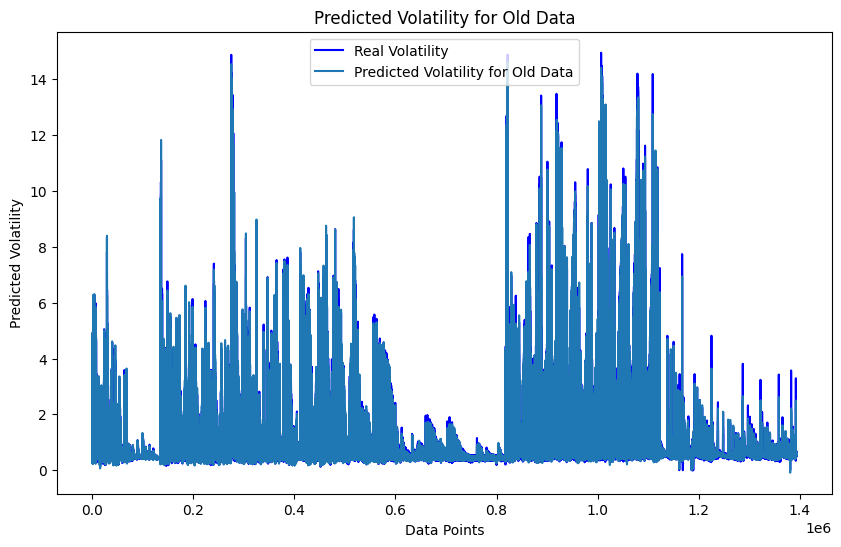

In [39]:
#Just to see how my test data perfomed to compare vissually


# Step 1: Preprocess your old data (if needed)
df_old_data_new = df.dropna()

# Step 2: Prepare the features for old data
X_old_data = df_old_data_new.drop(columns=["Volatility","Symbol"])  # Exclude 'Volatility' or other unnecessary columns

# Step 3: Make predictions using your previously trained model
y_pred_old_data = model.predict(X_old_data)

# Step 4: Show the predictions for old data
print("Predicted Volatility for Old Data:", y_pred_old_data)

# Step 5: Plot the predictions for old data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df["Volatility"].values, label='Real Volatility', color='blue')  # Plot real volatility
plt.plot(y_pred_old_data, label='Predicted Volatility for Old Data')
plt.title('Predicted Volatility for Old Data')
plt.xlabel('Data Points')
plt.ylabel('Predicted Volatility')
plt.legend()
plt.show()


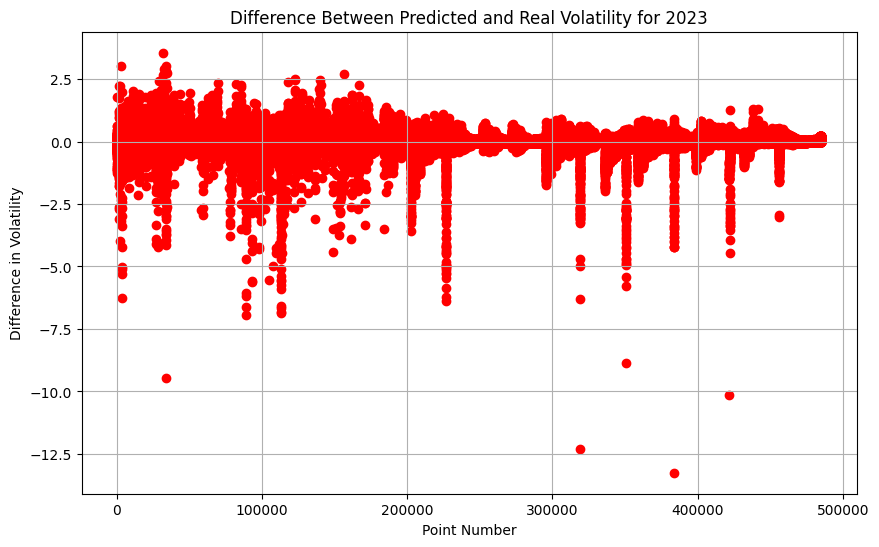

In [40]:
vol_diff = y_pred_2023 - df_2023_new["Volatility"].values


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(vol_diff)), vol_diff, color='red')  # Plot points with corresponding difference
plt.title('Difference Between Predicted and Real Volatility for 2023')
plt.xlabel('Point Number')
plt.ylabel('Difference in Volatility')
plt.grid(True)
plt.show()

In [41]:
postive_diff_count=(vol_diff>0).sum()
negative_diff_count = (vol_diff < 0).sum()

In [42]:
print(postive_diff_count)
print(negative_diff_count)

253605
231652


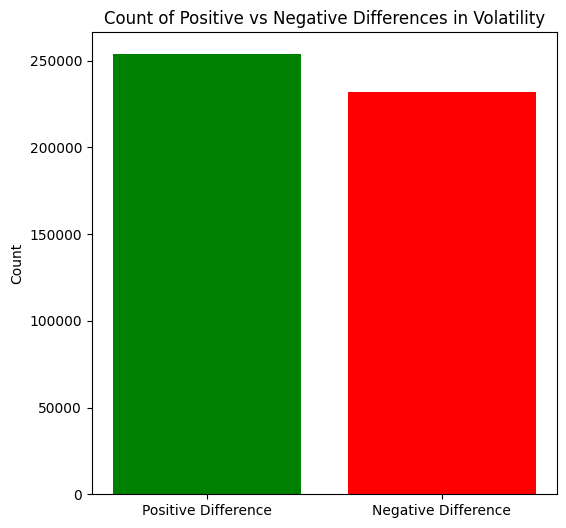

In [43]:

# Optionally, if you want to visualize the count of positive vs. negative differences:
import matplotlib.pyplot as plt

labels = ['Positive Difference', 'Negative Difference']
counts = [postive_diff_count, negative_diff_count]

plt.figure(figsize=(6, 6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Count of Positive vs Negative Differences in Volatility')
plt.ylabel('Count')
plt.show()

In [72]:
df_2023_new.columns

Index(['Symbol', 'Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low',
       'Last', 'LastSize', 'Settle', 'Previous', 'Volume', 'Volatility',
       'Theoretical', 'Price', 'UnderlyingPrice', 'Rate', 'DaysToExp', 'Delta',
       'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile',
       'Underlying_RollingVol', 'OptionType_Put', 'Position', 'diff',
       'Position_Size', 'Underlying_Position', 'underlying_position_value',
       'underlying_position_value_cumsum', 'option_position_value',
       'option_position_value_cumsum', 'total_position_value',
       'cumulative_profit_loss', 'hedge_shares', 'hedge_position_value',
       'hedged_total_value', 'hedged_cumulative_profit_loss'],
      dtype='object')

In [44]:
#NOW I WILL START TRADING 
#I WILL START BY MAKING A COLUMN CALLED POSITION WHICH WILL TELL WHETHER TO GO BUY / SELL CALL OR PUT 
# Step 1: Add a new column for position strategy
df_2023_new['Position'] = None
df_2023_new['diff'] = y_pred_2023 - df_2023_new['Volatility']
# Step 2: Assign positions based on 'diff' and 'OptionType_Put'
df_2023_new['Position'] = df_2023_new.apply(
    lambda row: 'Buy Call' if row['diff'] > 0 and row['OptionType_Put'] == 0 else
                ('Sell Put' if row['diff'] > 0 and row['OptionType_Put'] == 1 else
                 ('Sell Call' if row['diff'] < 0 and row['OptionType_Put'] == 0 else 'Buy Put')), axis=1)





In [45]:
# Step 3: Display the updated DataFrame
print(df_2023_new[['diff', 'OptionType_Put', 'Position']].head(10))

         diff  OptionType_Put   Position
169  0.021295           False   Buy Call
170  0.124391           False   Buy Call
178 -0.159665           False  Sell Call
179 -0.208347           False  Sell Call
180 -0.194982           False  Sell Call
188 -0.039967           False  Sell Call
189  0.139687           False   Buy Call
190 -0.112382           False  Sell Call
198  0.001650           False   Buy Call
199 -0.175543           False  Sell Call


In [74]:
#A column to calc how many call / puts to take action on , 
# WE WILL USE THE THIS FORMULA I MADE IF DIFF = X THEN POSN SIZE = 100*X
df_2023_new['Position_Size'] = (df_2023_new['diff']) * df_2023_new['Volume'] * 100
# Display the updated DataFrame
print(df_2023_new[['diff', 'Position', 'Position_Size']].head(20))

         diff   Position  Position_Size
169  0.021295   Buy Call       0.000000
170  0.124391   Buy Call       0.000000
178 -0.159665  Sell Call      -0.000000
179 -0.208347  Sell Call      -0.000000
180 -0.194982  Sell Call      -0.000000
188 -0.039967  Sell Call      -0.000000
189  0.139687   Buy Call       0.000000
190 -0.112382  Sell Call      -0.000000
198  0.001650   Buy Call       0.000000
199 -0.175543  Sell Call      -0.000000
200  0.074489   Buy Call       0.000000
208 -0.129630  Sell Call      -0.000000
209  0.219237   Buy Call       0.000000
210  0.053166   Buy Call       0.000000
217  0.023935   Sell Put     619.910059
218  0.241347   Buy Call       0.000000
219 -0.137412  Sell Call      -0.000000
220  0.136831   Buy Call       0.000000
228  0.002165   Buy Call       0.000000
229 -0.086295  Sell Call      -0.000000


In [77]:
print("Number of rows where Volume = 0:", (df_2023_new['Volume'] == 0).sum())
print("Total number of rows:", len(df_2023_new))


Number of rows where Volume = 0: 214431
Total number of rows: 485257


In [47]:
df_2023_new.describe()
print(df_2023_new["Price"])

169        38.550
170        31.975
178        32.250
179        35.525
180        30.975
           ...   
554629    503.750
554630    512.750
554631    541.500
554632    531.000
554633    524.500
Name: Price, Length: 485257, dtype: float64


In [48]:
# Calculate the amount of underlying asset to buy/sell for delta hedging
df_2023_new['Underlying_Position'] = df_2023_new['Position_Size'] * df_2023_new['Delta']

# Display the updated DataFrame with the new 'Underlying_Position' column
print(df_2023_new[['Position_Size', 'Delta', 'Underlying_Position']].head(20))


     Position_Size     Delta  Underlying_Position
169              2  0.896425             1.792849
170             12  0.964076            11.568915
178            -15  0.919551           -13.793264
179            -20  0.997885           -19.957695
180            -19  0.963079           -18.298492
188             -3  0.924707            -2.774120
189             13  0.893285            11.612711
190            -11  0.962026           -10.582289
198              0  0.917729             0.000000
199            -17  0.997855           -16.963542
200              7  0.960913             6.726393
208            -12  0.981208           -11.774500
209             21  0.916469            19.245845
210              5  0.959744             4.798719
217              2 -0.004962            -0.009923
218             24  0.959308            23.023392
219            -13  0.993243           -12.912156
220             13  0.958505            12.460568
228              0  0.892077             0.000000


In [50]:
df_2023_new.columns

Index(['Symbol', 'Strike', 'AskPrice', 'BidPrice', 'Open', 'High', 'Low',
       'Last', 'LastSize', 'Settle', 'Previous', 'Volume', 'Volatility',
       'Theoretical', 'Price', 'UnderlyingPrice', 'Rate', 'DaysToExp', 'Delta',
       'Gamma', 'Moneyness', 'Log moneyness', 'Diff', 'Moneyness_percentile',
       'Underlying_RollingVol', 'OptionType_Put', 'Position', 'diff',
       'Position_Size', 'Underlying_Position'],
      dtype='object')

In [51]:
print(df_2023_new.dtypes)


Symbol                    object
Strike                   float64
AskPrice                 float64
BidPrice                 float64
Open                     float64
High                     float64
Low                      float64
Last                     float64
LastSize                   int64
Settle                   float64
Previous                 float64
Volume                     int64
Volatility               float64
Theoretical              float64
Price                    float64
UnderlyingPrice          float64
Rate                     float64
DaysToExp                  int64
Delta                    float64
Gamma                    float64
Moneyness                float64
Log moneyness            float64
Diff                     float64
Moneyness_percentile     float64
Underlying_RollingVol    float64
OptionType_Put              bool
Position                  object
diff                     float64
Position_Size              int64
Underlying_Position      float64
dtype: obj

In [84]:
# df_2023_new['hedge_shares'] = df_2023_new['Position_Size'] * df_2023_new['Delta']
# df_2023_new['hedge_position_value'] = df_2023_new['hedge_shares'] * df_2023_new['UnderlyingPrice']
# df_2023_new['hedged_total_value'] = df_2023_new['option_position_value'] + df_2023_new['hedge_position_value']
# df_2023_new['hedged_cumulative_profit_loss'] = df_2023_new['hedged_total_value'].cumsum()


#LETS USE VEGA TO CALC OUR POSTN SO WE DO VEGA WE HAD STORED BEFORE
df_2023_vega.head(10)

138    0.0164
139    0.0146
140    0.0040
141    0.0033
148    0.0011
149    0.0162
150    0.0047
151    0.0037
158    0.0011
159    0.0175
Name: Vega, dtype: float64

In [102]:
# Step 1: Compute target Vega exposure
df_2023_updated = df_2023_new.copy()  # Copy original
df_2023_updated['Vega'] = df_2023_vega  # Add Vega

# Compute target Vega exposure
df_2023_updated['V_target'] = df_2023_updated['diff'] * df_2023_updated['UnderlyingPrice']

# Step 2: Compute the number of contracts to trade
df_2023_updated['Position_Size'] = df_2023_updated['V_target'] / df_2023_updated['Vega']

# Step 3: Handle cases where Vega is zero or too small
df_2023_updated.loc[df_2023_updated['Vega'] < 0.005, 'Position_Size'] = 0  # Ignore small Vega trades

# Step 4: Convert to whole contracts
df_2023_updated['Position_Size'] = df_2023_updated['Position_Size'].fillna(0)
df_2023_updated['Position_Size'] = df_2023_updated['Position_Size'].astype(int)

# Step 5: Cap max contract size (avoid huge orders)
MAX_CONTRACTS = 10000
df_2023_updated['Position_Size'] = df_2023_updated['Position_Size'].clip(-MAX_CONTRACTS, MAX_CONTRACTS)

# Print first few rows to verify
print(df_2023_updated[['diff', 'UnderlyingPrice', 'Vega', 'V_target', 'Position_Size']].head())

# Describe new position sizes
print(df_2023_updated["Vega"].describe())
print(df_2023_updated["Position_Size"].describe())


         diff  UnderlyingPrice    Vega   V_target  Position_Size
169  0.021295           147.49  0.0197   3.140790            159
170  0.124391           142.65  0.0059  17.744386           3007
178 -0.159665           143.15  0.0194 -22.856000          -1178
179 -0.208347           147.49  0.0007 -30.729133              0
180 -0.194982           142.65  0.0060 -27.814237          -4635
count    485257.000000
mean          0.511783
std           0.589321
min           0.000000
25%           0.066300
50%           0.270000
75%           0.776000
max           2.945700
Name: Vega, dtype: float64
count    485257.00000
mean        148.02868
std        1709.00296
min      -10000.00000
25%         -18.00000
50%           0.00000
75%          33.00000
max       10000.00000
Name: Position_Size, dtype: float64


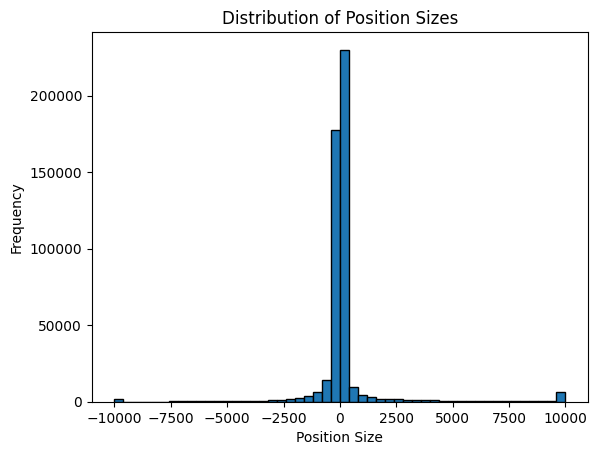

In [103]:
import matplotlib.pyplot as plt

plt.hist(df_2023_updated['Position_Size'], bins=50, edgecolor='black')
plt.xlabel("Position Size")
plt.ylabel("Frequency")
plt.title("Distribution of Position Sizes")
plt.show()



In [ ]:
#LETS MOVE ON TO DELTA HEDGING 
df_2023_updated['Delta_Pos'] = df_2023_updated['Position_Size'] * df_2023_updated['Delta']
total_portfolio_delta = df_2023_updated['Delta_Pos'].sum()
print("Total Portfolio Delta:", total_portfolio_delta)


In [114]:
# Step 1: Compute option position value FIRST before using it
df_2023_updated['option_position_value'] = df_2023_updated['Position_Size'] * df_2023_updated['Price'] * 100

# Step 2: Compute delta hedge  
df_2023_updated['hedge_shares'] = df_2023_updated['Position_Size'] * df_2023_updated['Delta']  # No extra * 100!

# Step 3: Compute hedge position value
df_2023_updated['hedge_position_value'] = df_2023_updated['hedge_shares'] * df_2023_updated['UnderlyingPrice']

# Step 4: Compute hedged total value
df_2023_updated['hedged_total_value'] = df_2023_updated['option_position_value'] + df_2023_updated['hedge_position_value']

# Step 5: Compute cumulative P&L
df_2023_updated['hedged_cumulative_profit_loss'] = df_2023_updated['hedged_total_value'].cumsum()


In [115]:
print("Total P&L After Delta Hedging:", df_2023_updated['hedged_cumulative_profit_loss'].iloc[-1])


Total P&L After Delta Hedging: 1324416901366.7756
